# Land use classification using aerial images

For this project, I plan to use the Convolutional Neural Network (CNN) to build a image classifier to classify the aerial images to 6 different land use types (forest, urban, grass, barren land, water, and roads). 

The `NAIP` dataset are available on [Kaggle](https://www.kaggle.com/crawford/deepsat-sat6). The dataset that is available is approximately 2.4 GB when compressed (5.26 GB when extracted), with a total number of 405000 images -- 324000 images in the training set and 81000 in the test set. Each image is of 28 (height) x 28 (height) pixels with 4 channels (Red, Green, Blue, and Near Infrared). Each image in the training or test set has an associated label denoting the class of the land use type among the 6 possible categories. 

## 1. import data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
import os
from glob import glob
import itertools

%matplotlib inline

In [3]:
def load_data_and_labels(data, labels):
    data_df = pd.read_csv(data, header=None)
    X = data_df.values.reshape((-1,28,28,4)).clip(0,255).astype(np.uint8)
    labels_df = pd.read_csv(labels, header=None)
    Y = labels_df.values.getfield(dtype=np.int8)
    return X, Y

In [55]:
X_train, y_train = load_data_and_labels(data='X_train_sat6.csv',
                                        labels='y_train_sat6.csv')


In [4]:
X_test, y_test = load_data_and_labels(data='X_test_sat6.csv',
                                      labels='y_test_sat6.csv')

The `sat6annotations.csv` contains metadata concerning the class of each label.

In [5]:
annotation = pd.read_csv('sat6annotations.csv', header=None)

class_names = list(annotation.iloc[:, 0])
print(annotation)

             0  1  2  3  4  5  6
0     building  1  0  0  0  0  0
1  barren_land  0  1  0  0  0  0
2        trees  0  0  1  0  0  0
3    grassland  0  0  0  1  0  0
4         road  0  0  0  0  1  0
5        water  0  0  0  0  0  1


In [12]:
import tensorflow as tf
from keras.callbacks import TensorBoard
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, ZeroPadding2D, Convolution2D,MaxPooling2D
from keras.models import Sequential

## Build the CNN model

I use a series of Conv2D and MaxPool2D layers for the convolutional structure. Dropout layers were used to prevent over-fitting. The final output is a Dense layer of 6 units, and the softmax function is used to predict the class probability.

In [14]:
tf.reset_default_graph()

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(28,28,4)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 16)        592       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
__________

In [15]:
tbcallback = TensorBoard(log_dir='./Graph/', histogram_freq=1, write_graph=True, write_grads=True)

model1 = model.fit(X_train, y_train, batch_size=200, validation_split=0.1, epochs=6, verbose=1, validation_data=(X_test, y_test), callbacks=[tbcallback])

Train on 324000 samples, validate on 81000 samples
Epoch 1/6
324000/324000 [==============================] - 657s 2ms/step - loss: 0.3638 - acc: 0.8832 - val_loss: 0.1110 - val_acc: 0.9586
Epoch 2/6
324000/324000 [==============================] - 602s 2ms/step - loss: 0.1036 - acc: 0.9642 - val_loss: 0.0801 - val_acc: 0.9727
Epoch 3/6
324000/324000 [==============================] - 589s 2ms/step - loss: 0.0794 - acc: 0.9729 - val_loss: 0.0661 - val_acc: 0.9757
Epoch 4/6
324000/324000 [==============================] - 649s 2ms/step - loss: 0.0692 - acc: 0.9762 - val_loss: 0.0463 - val_acc: 0.9836
Epoch 5/6
324000/324000 [==============================] - 605s 2ms/step - loss: 0.0604 - acc: 0.9793 - val_loss: 0.0530 - val_acc: 0.9821
Epoch 6/6
324000/324000 [==============================] - 606s 2ms/step - loss: 0.0572 - acc: 0.9805 - val_loss: 0.0511 - val_acc: 0.9819


It can be seen that our model reached pretty good accuracy (98%) on the test set after 6 epochs. This is possibly very close to the  accuracy level of human diagnosis.

## Output

We first plotting the accuracy of the model on training and testing set. It can be seen that as the training goes on, the accuracy on both the training and the test set increases and eventually becomes stable.

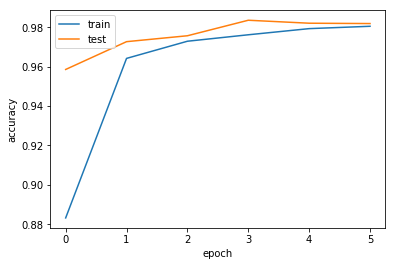

In [17]:
plt.plot(model1.history['acc'])
plt.plot(model1.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()
#plt.savefig('accuracy.png')

The cross-entropy loss also decreases as the training goes on, and eventually the loss on both training and test set becomes stable.

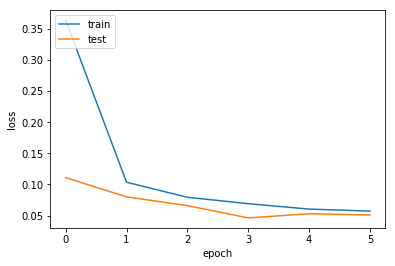

In [19]:
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.savefig('loss.png')
#plt.show()

In [21]:
json_file = model.to_json()
with open('deepsat6-6epochs-model.json', 'w') as f:
    f.write(json_file)
model.save_weights('CNN.h5')

In [22]:
from IPython.display import SVG
import pydot
import graphviz

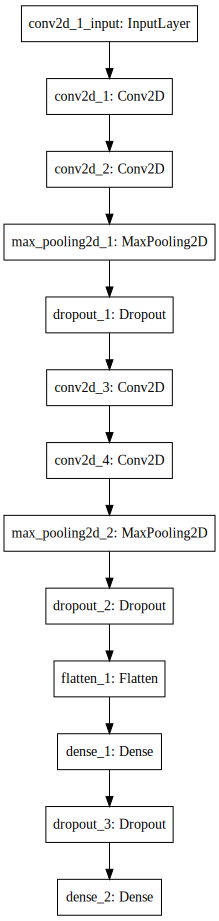

In [46]:
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [23]:
import pydot
import graphviz
from keras.utils.vis_utils import plot_model
plot_model(model, to_file = 'model.png', show_shapes=True, show_layer_names=True)

In [7]:
from sklearn.metrics import confusion_matrix
y_test_de_encod = np.where(y_test == 1)[-1]
c_matrix = confusion_matrix(y_test_de_encod, model.predict_classes(X_test))

Confusion matrix, without normalization
[[ 3629     0     1     0    75     9]
 [    2 17742     3   602    18     0]
 [    0     1 14015   169     0     0]
 [   23   396    31 12141     5     0]
 [  112     2    12     5  1939     0]
 [    0     0     0     0     0 30068]]


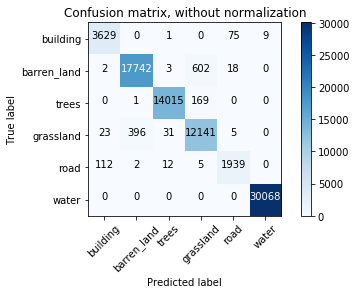

Normalized confusion matrix
[[  9.77e-01   0.00e+00   2.69e-04   0.00e+00   2.02e-02   2.42e-03]
 [  1.09e-04   9.66e-01   1.63e-04   3.28e-02   9.80e-04   0.00e+00]
 [  0.00e+00   7.05e-05   9.88e-01   1.19e-02   0.00e+00   0.00e+00]
 [  1.83e-03   3.14e-02   2.46e-03   9.64e-01   3.97e-04   0.00e+00]
 [  5.41e-02   9.66e-04   5.80e-03   2.42e-03   9.37e-01   0.00e+00]
 [  0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   1.00e+00]]


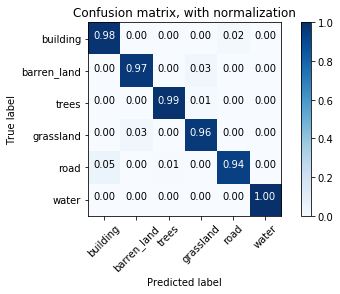

In [285]:
plt.figure()
plot_confusion_matrix(c_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('confusionmatrix.png')
plt.show()
plt.figure()
plot_confusion_matrix(c_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()
#plt.savefig('Normalize_confusionmatrix.png')

Based on the confusion matrix, the model did a pretty good job. The highest error comes from wrongly classify 5% of the road as buildings, possibly due to the similarity of materials used to build the two. Also, 3% of the barren land were classified as grass.

In [29]:
predictions = model.predict_classes(X_test)

In [276]:
b_g_index = np.where((predictions == 3)&(y_test_de_encod==1))[0]
b_b_index = np.where((predictions ==1)&(y_test_de_encod==1))[0]
g_g_index = np.where((predictions ==3)&(y_test_de_encod==3))[0]
g_b_index = np.where((predictions ==1)&(y_test_de_encod==3))[0]

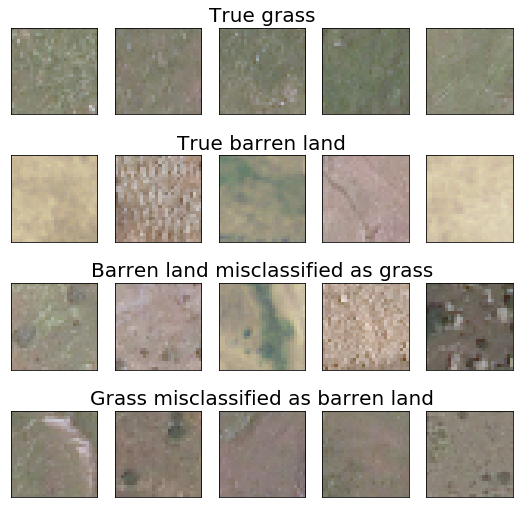

In [287]:
fig, axs = plt.subplots(4,5,figsize=(9,9))
for i,ax in enumerate(fig.axes):
    r,c = divmod(i, 5)
    if r == 0:
        rand_indices = np.random.randint(0, len(g_g_index),1)
        img = X_test[g_g_index][rand_indices][:,:,:,:3].reshape(28,28,3)
        if c == 2:
            ax.set_title('True grass', size=20)
    if r == 1:
        rand_indices = np.random.randint(0, len(b_b_index),1)
        img = X_test[b_b_index][rand_indices][:,:,:,:3].reshape(28,28,3)
        if c == 2:
            ax.set_title('True barren land', size=20)
    if r == 2:
        rand_indices = np.random.randint(0, len(b_g_index),1)
        img = X_test[b_g_index][rand_indices][:,:,:,:3].reshape(28,28,3)
        if c == 2:
            ax.set_title('Barren land misclassified as grass', size=20)
    if r == 3:
        rand_indices = np.random.randint(0, len(g_b_index),1)
        img = X_test[g_b_index][rand_indices][:,:,:,:3].reshape(28,28,3)
        if c == 2:
            ax.set_title('Grass misclassified as barren land', size=20)
            
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()
#plt.savefig('bgmisclass.png')    

A visual inspection was taken to see the mis-classification of barren land as grass. As the figure shows, the differences between the mis-classified grass and barren land are minimal. For either the barren land mis-classified as grass or the grass mis-classified otherwise, it can be difficult to tell the difference visually. Thus, the mis-classification between grass and barren land can be a consequence of the ambiguity of the two classes.

In [286]:
bu_r_index = np.where((predictions == 4)&(y_test_de_encod==0))[0]
bu_bu_index = np.where((predictions ==0)&(y_test_de_encod==0))[0]
r_bu_index = np.where((predictions ==4)&(y_test_de_encod==4))[0]
r_r_index = np.where((predictions ==0)&(y_test_de_encod==4))[0]

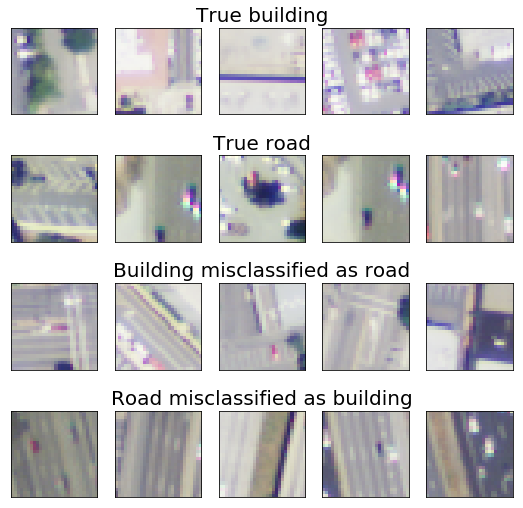

In [291]:
fig, axs = plt.subplots(4,5,figsize=(9,9))
for i,ax in enumerate(fig.axes):
    r,c = divmod(i, 5)
    if r == 0:
        rand_indices = np.random.randint(0, len(bu_bu_index),1)
        img = X_test[bu_bu_index][rand_indices][:,:,:,:3].reshape(28,28,3)
        if c == 2:
            ax.set_title('True building', size=20)
    if r == 1:
        rand_indices = np.random.randint(0, len(r_r_index),1)
        img = X_test[r_r_index][rand_indices][:,:,:,:3].reshape(28,28,3)
        if c == 2:
            ax.set_title('True road', size=20)
    if r == 2:
        rand_indices = np.random.randint(0, len(bu_r_index),1)
        img = X_test[bu_r_index][rand_indices][:,:,:,:3].reshape(28,28,3)
        if c == 2:
            ax.set_title('Building misclassified as road', size=20)
    if r == 3:
        rand_indices = np.random.randint(0, len(r_bu_index),1)
        img = X_test[r_bu_index][rand_indices][:,:,:,:3].reshape(28,28,3)
        if c == 2:
            ax.set_title('Road misclassified as building', size=20)
            
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
#plt.show()
plt.savefig('burmisclass.png')    

In [37]:
for layer in model.layers:
    weights = layer.get_weights()

In [109]:
def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)

We can also visualize the weights of different filters to see what sort of features each filter is capturing.

W shape :  (3, 3, 32, 32)


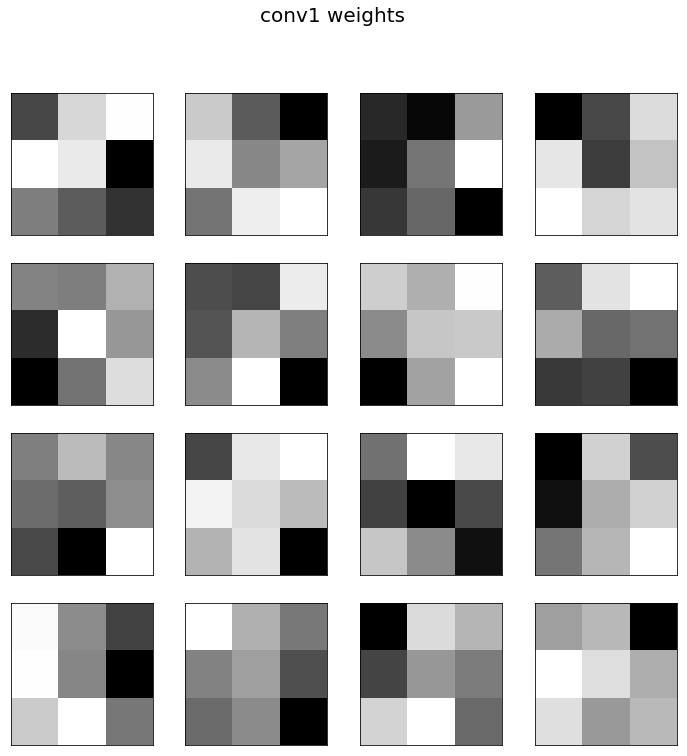

In [275]:
from matplotlib.cm import binary

W = model.layers[4].get_weights()[0]
W = np.squeeze(W)
print("W shape : ", W.shape)

fig, axs = plt.subplots(4,4, 
                        figsize=(12, 12))

fig.suptitle('conv1 weights', size=20)
for i, ax in enumerate(fig.axes):
    ax.imshow(W[:,:,0,i]+0.5, cmap=binary)
    ax.set_xticks([])
    ax.set_yticks([])

fig.savefig('Conv1weights')

W shape :  (3, 3, 32, 64)


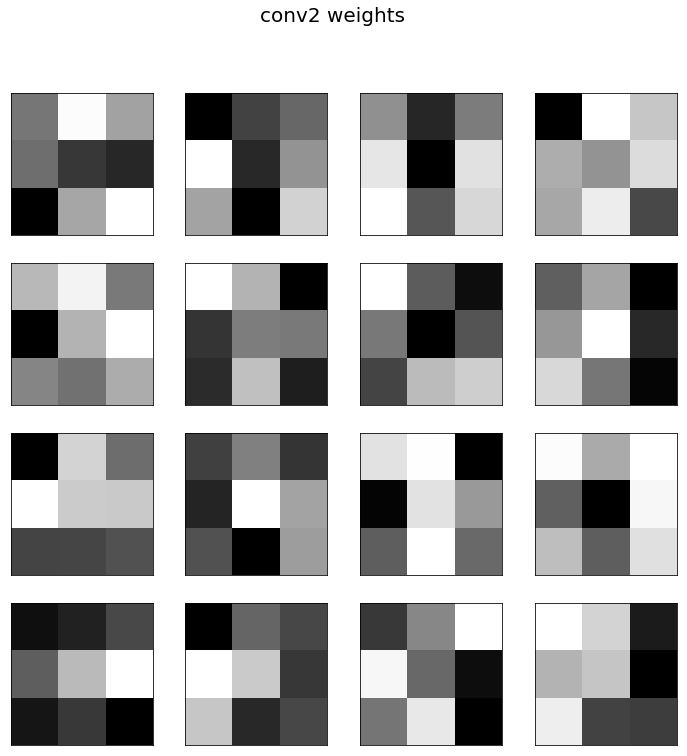

In [274]:
from matplotlib.cm import binary

W = model.layers[5].get_weights()[0]
W = np.squeeze(W)
print("W shape : ", W.shape)

fig, axs = plt.subplots(4,4, 
                        figsize=(12, 12))

fig.suptitle('conv2 weights', size=20)
for i, ax in enumerate(fig.axes):
    ax.imshow(W[:,:,0,i]+0.5, cmap=binary)
    ax.set_xticks([])
    ax.set_yticks([])

fig.savefig('Conv2weights')

The true color (R,G,B) and the false color (NIR, G, B) visualization of images. The false color excels at exaggerating the vegetated and non-vegetated areas.

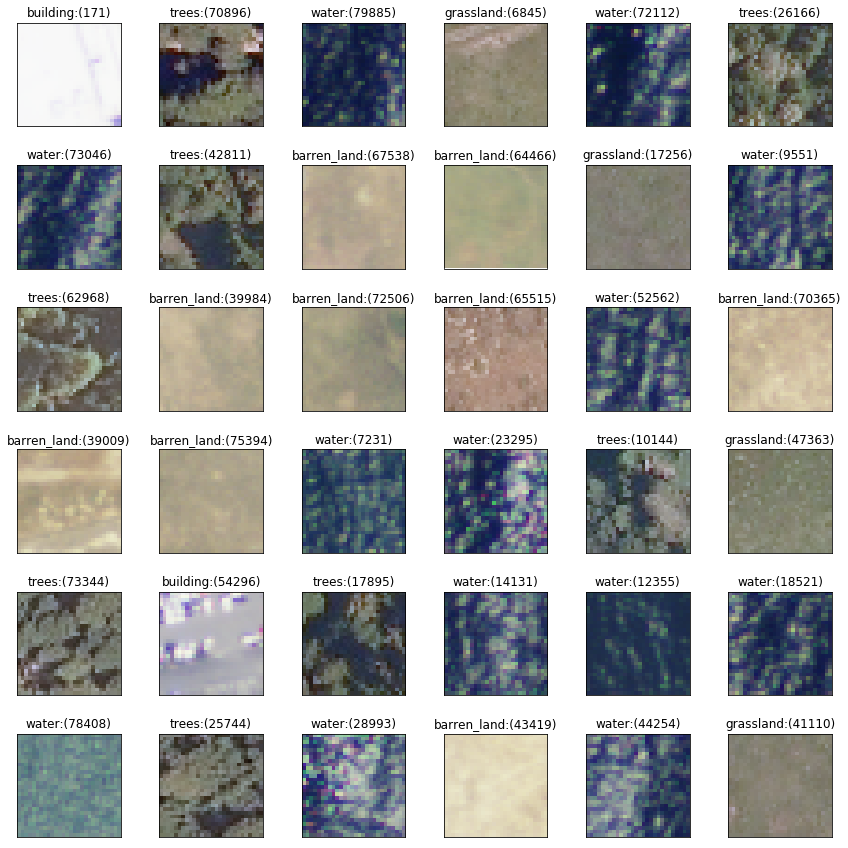

In [59]:
fig, axs = plt.subplots(6,6,figsize=(12,12))
rand_ns = []
for i,ax in enumerate(fig.axes):
    n = np.random.randint(0,len(X_test)-1)
    rand_ns.append(n)
    X = X_test[n:n+1]
    ax.set_title('{0}:({1})'.format(class_names[y_test_de_encod[n]],n))
    data = np.squeeze(X)
    im = ax.imshow(data[:,:,:3], vmin=data.min(), vmax=data.max(), interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig('truecolor')

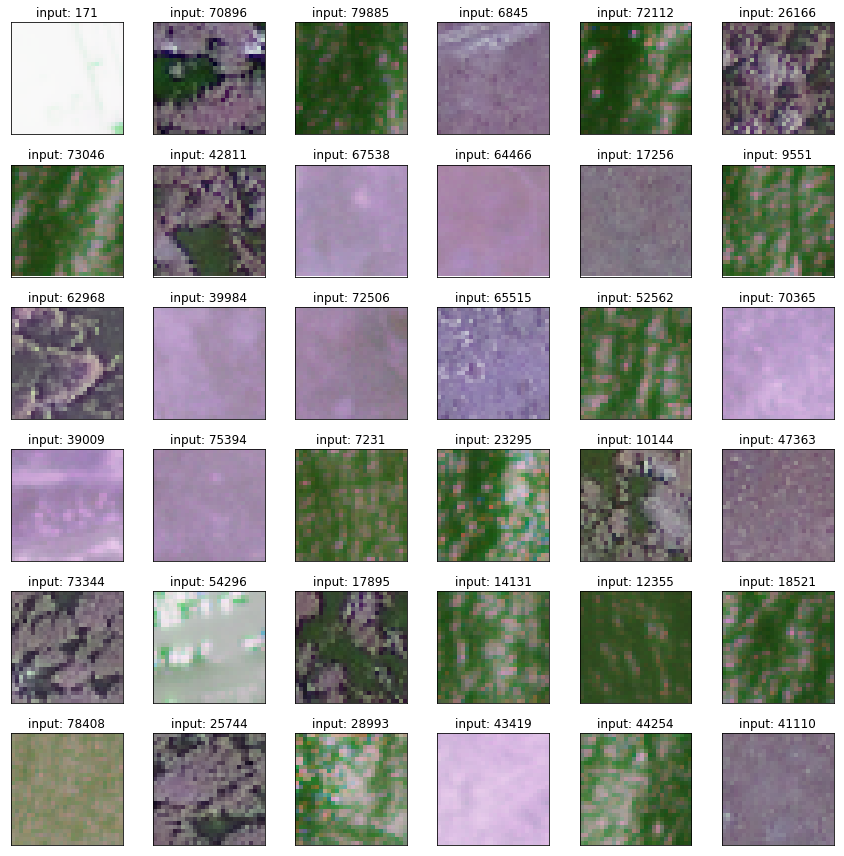

In [62]:
fig, axs = plt.subplots(6,6,figsize=(12,12))
for i,ax in enumerate(fig.axes):
    n = rand_ns[i]
    X = X_test[n:n+1]
    ax.set_title('input: {0}'.format(n))
    data = np.squeeze(X)
    im = ax.imshow(data[:,:,np.argsort([3,0,1])], vmin=data.min(), vmax=data.max(), interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig('falsecolor')

In [26]:
df_xtest = pd.DataFrame(X_test.reshape(81000*28*28, 4), columns=['R','G','B','NIR'])

df_xtest['y'] = np.repeat(y_test_de_encod, 28*28)

df_xtest_sub = df_xtest.sample(frac=0.0001)


We can also use the violin plot to see the spectral responses from different types of land use.

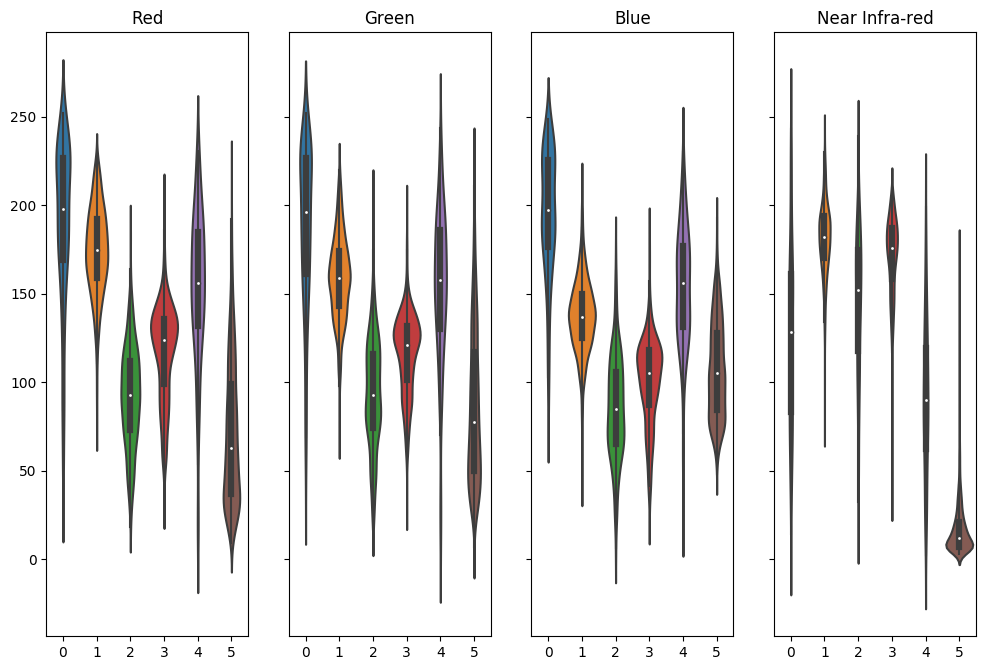

In [54]:
import seaborn as sns
f, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(12,8), nrows=1, ncols=4, sharey=True,dpi=100)
sns.violinplot(x='y', y='R',data=df_xtest_sub,ax=ax1)
ax1.set_title('Red')
ax1.set_ylabel('')
ax1.set_xlabel('')
sns.violinplot(x='y', y='G',data=df_xtest_sub,ax=ax2)
ax2.set_title('Green')
ax2.set_ylabel('')
ax2.set_xlabel('')
sns.violinplot(x='y', y='B',data=df_xtest_sub,ax=ax3)
ax3.set_title('Blue')
ax3.set_ylabel('')
ax3.set_xlabel('')
sns.violinplot(x='y', y='NIR',data=df_xtest_sub,ax=ax4)
ax4.set_title('Near Infra-red')
ax4.set_ylabel('')
ax4.set_xlabel('')
plt.savefig('spectral.png')